# Regresiones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Resultado del mes anterior

In [2]:
imacec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20Imacec.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imacec.columns = ['imacec']
imacec.tail()

,imacec
Fecha,
2021-08-01,18.951276
2021-09-01,14.753843
2021-10-01,14.951209
2021-11-01,14.265823
2021-12-01,10.118327


In [54]:
# ACTUALIZAR nombre de documento
prediccion = pd.read_csv('pred_2022_01.csv', index_col=0)
prediccion

,prediccion
percepcion,
IPECO,2.459699
IPEC,11.100156
ICE,11.346681
IMCE,6.439596
Consumidores,6.474250
Empresarios,8.616428
Todos,8.147850


In [53]:
prediccion['imacec'] = imacec['imacec'][-1]
prediccion['abs-error'] = np.abs(prediccion['prediccion'] - prediccion['imacec'])
prediccion.sort_values('abs-error').round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
IPEC,11.10,10.12,0.98,1
ICE,11.35,10.12,1.23,2
Empresarios,8.62,10.12,1.50,3
Todos,8.15,10.12,1.97,4
Consumidores,6.47,10.12,3.64,5
IMCE,6.44,10.12,3.68,6
IPECO,2.46,10.12,7.66,7


In [5]:
prediccion = prediccion.sort_values('abs-error')
prediccion['ranking'] = np.arange(1,8,1)

In [6]:
# ACTUALIZAR nombre de documento
prediccion.to_csv('res_2022_01.csv')
prediccion.round(2)

,prediccion,imacec,abs-error,ranking
percepcion,,,,
IPEC,11.10,10.12,0.98,1
ICE,11.35,10.12,1.23,2
Empresarios,8.62,10.12,1.50,3
Todos,8.15,10.12,1.97,4
Consumidores,6.47,10.12,3.64,5
IMCE,6.44,10.12,3.68,6
IPECO,2.46,10.12,7.66,7


In [7]:
# ACTUALIZAR nombre (segunda fila)
ranking_actual = prediccion[['ranking']]
ranking_actual.columns = ['R-2022-01']

ranking_acumulado = pd.read_csv('ranking_acumulado.csv', index_col='percepcion')
ranking_acumulado = pd.concat([ranking_acumulado, ranking_actual], axis=1)
ranking_acumulado.to_csv('ranking_acumulado.csv')
ranking_acumulado

,R-2011-05,R-2021-06,R-2021-07,R-2021-08,R-2021-09,R-2021-10,R-2021-11,R-2021-12,R-2022-01
percepcion,,,,,,,,,
IMCE,1,4,4,2,3,3,4,4,6
ICE,2,2,2,4,4,4,3,3,2
Empresarios,3,3,3,1,1,2,2,1,3
IPECO,4,7,7,5,6,5,5,6,7
Todos,5,1,1,3,2,1,1,2,4
Consumidores,6,5,5,6,7,7,7,5,5
IPEC,7,6,6,7,5,6,6,7,1


In [8]:
# Ranking promedio
ranking_acumulado.mean(axis=1).sort_values().round(1)

percepcion
Empresarios     2.1
Todos           2.2
ICE             2.9
IMCE            3.4
IPEC            5.7
IPECO           5.8
Consumidores    5.9
dtype: float64

In [9]:
# Número de victorias
(ranking_acumulado == 1).sum(axis=1).sort_values(ascending=False)

percepcion
Todos           4
Empresarios     3
IMCE            1
IPEC            1
ICE             0
IPECO           0
Consumidores    0
dtype: int64

# Carga y Preprocesamiento de los datos de percepciones

In [10]:
ipeco = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20IPECO.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipeco.columns = ['ipeco', 'coyuntura', 'expectativas', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if', 'ipeco-m3']
ipeco = ipeco[['ipeco', 'ipeco-sea', 'ipeco-da', 'ipeco-sef', 'ipeco-df', 'ipeco-if']]
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if
Fecha,,,,,,
2021-09-01,92.280043,88.003663,159.597619,76.303192,116.461577,75.952293
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541
2021-11-01,97.043465,93.914647,235.903771,79.676596,102.048445,71.664664
2021-12-01,106.915316,118.678775,242.537104,76.918776,140.550239,67.307692
2022-01-01,112.174136,115.119364,228.934400,90.616476,134.596730,82.925580


In [11]:
ipeco['ipeco-m3'] = ipeco['ipeco'].rolling(3).mean()
ipeco['ipeco-m6'] = ipeco['ipeco'].rolling(6).mean()
ipeco['ipeco-presente'] = ipeco[['ipeco-sea', 'ipeco-da']].mean(axis=1)
ipeco['ipeco-futuro'] = ipeco[['ipeco-sef', 'ipeco-df', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-personal'] = ipeco[['ipeco-sea', 'ipeco-sef', 'ipeco-if']].mean(axis=1)
ipeco['ipeco-nacional'] = ipeco[['ipeco-df', 'ipeco-da']].mean(axis=1)
ipeco.tail()

,ipeco,ipeco-sea,ipeco-da,ipeco-sef,ipeco-df,ipeco-if,ipeco-m3,ipeco-m6,ipeco-presente,ipeco-futuro,ipeco-personal,ipeco-nacional
Fecha,,,,,,,,,,,,
2021-09-01,92.280043,88.003663,159.597619,76.303192,116.461577,75.952293,87.143026,78.141632,123.800641,89.572354,80.086383,138.029598
2021-10-01,84.645442,79.757544,154.462941,80.805932,106.818182,57.083541,86.188151,83.541073,117.110243,81.569218,72.549006,130.640561
2021-11-01,97.043465,93.914647,235.903771,79.676596,102.048445,71.664664,91.322983,86.999625,164.909209,84.463235,81.751969,168.976108
2021-12-01,106.915316,118.678775,242.537104,76.918776,140.550239,67.307692,96.201408,91.672217,180.607940,94.925569,87.635081,191.543672
2022-01-01,112.174136,115.119364,228.934400,90.616476,134.596730,82.925580,105.377639,95.782895,172.026882,102.712929,96.220473,181.765565


In [12]:
ipec = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/GFK%20ADIMARK%20IPEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ipec.columns = ['ipec-sepa', 'ipec-sena', 'ipec-senf12m', 'ipec-senf5y', 'ipec-ec', 'ipec']
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec
Fecha,,,,,,
2021-09-01,40.188671,41.584583,44.678387,26.695692,36.160355,37.861538
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089
2021-11-01,38.151100,35.973606,39.699547,21.955841,29.027548,32.961529
2021-12-01,39.452972,42.365562,48.175476,30.508467,27.394527,37.579399
2022-01-01,37.788666,41.993099,49.689941,31.098402,28.823929,37.878807


In [13]:
ipec['ipec-m3'] = ipec['ipec'].rolling(3).mean()
ipec['ipec-m6'] = ipec['ipec'].rolling(6).mean()
ipec['ipec-presente'] = ipec[['ipec-sepa', 'ipec-sena', 'ipec-ec']].mean(axis=1)
ipec['ipec-futuro'] = ipec[['ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec['ipec-personal'] = ipec[['ipec-sepa', 'ipec-ec']].mean(axis=1)
ipec['ipec-nacional'] = ipec[['ipec-sena', 'ipec-senf12m', 'ipec-senf5y']].mean(axis=1)
ipec.tail()

,ipec-sepa,ipec-sena,ipec-senf12m,ipec-senf5y,ipec-ec,ipec,ipec-m3,ipec-m6,ipec-presente,ipec-futuro,ipec-personal,ipec-nacional
Fecha,,,,,,,,,,,,
2021-09-01,40.188671,41.584583,44.678387,26.695692,36.160355,37.861538,38.200747,33.787559,39.311203,35.687039,38.174513,37.652887
2021-10-01,36.233318,35.555622,38.466400,26.122946,34.787159,34.233089,37.141669,35.342993,35.525366,32.294673,35.510239,33.381656
2021-11-01,38.151100,35.973606,39.699547,21.955841,29.027548,32.961529,35.018719,35.864710,34.384085,30.827694,33.589324,32.542998
2021-12-01,39.452972,42.365562,48.175476,30.508467,27.394527,37.579399,34.924672,36.562710,36.404354,39.341971,33.423750,40.349835
2022-01-01,37.788666,41.993099,49.689941,31.098402,28.823929,37.878807,36.139912,36.640790,36.201898,40.394172,33.306297,40.927148


In [14]:
ice = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/CEEN%20UDD%20ICE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
ice.columns = ['ice', 'ice-m3', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']
ice = ice[['ice', 'ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']]
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria
Fecha,,,,,,,
2021-09-01,6.847542,-31.250000,10.299901,-11.739750,12.500000,9.358825,19.805556
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.750000,-3.078373,-4.583333
2021-11-01,0.837188,-0.427807,9.961774,-33.911765,43.750000,7.002976,-12.177083
2021-12-01,3.357043,-23.529412,18.253269,-35.147059,43.750000,15.407242,-10.200000
2022-01-01,-7.515013,-2.673797,8.909196,-34.636364,1.354895,-11.691468,-6.531250


In [15]:
ice['ice-m'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-m3'] = ice['ice'].rolling(3).mean()
ice['ice-m6'] = ice['ice'].rolling(6).mean()
ice['ice-sagri'] = ice[['ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scom'] = ice[['ice-agricola', 'ice-construccion','ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-scons'] = ice[['ice-agricola', 'ice-comercio', 'ice-financiero', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sfin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion', 'ice-industria', 'ice-mineria']].mean(axis=1)
ice['ice-sind'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-mineria']].mean(axis=1)
ice['ice-smin'] = ice[['ice-agricola', 'ice-comercio', 'ice-construccion','ice-financiero', 'ice-industria']].mean(axis=1)
ice.tail()

,ice,ice-agricola,ice-comercio,ice-construccion,ice-financiero,ice-industria,ice-mineria,ice-m,ice-m3,ice-m6,ice-sagri,ice-scom,ice-scons,ice-sfin,ice-sind,ice-smin
Fecha,,,,,,,,,,,,,,,,
2021-09-01,6.847542,-31.250000,10.299901,-11.739750,12.500000,9.358825,19.805556,1.495755,6.761750,3.831056,8.044906,-0.265074,4.142856,-0.705094,-0.076859,-2.166205
2021-10-01,-1.814161,-35.294118,8.994236,-11.574866,18.750000,-3.078373,-4.583333,-4.464409,3.802240,4.113665,1.701533,-7.156138,-3.042318,-9.107291,-4.741616,-4.440624
2021-11-01,0.837188,-0.427807,9.961774,-33.911765,43.750000,7.002976,-12.177083,2.366349,1.956856,4.098101,2.925180,0.847264,9.621972,-5.910381,1.439024,5.275036
2021-12-01,3.357043,-23.529412,18.253269,-35.147059,43.750000,15.407242,-10.200000,1.422340,0.793357,3.777553,6.412690,-1.943846,8.736220,-7.043192,-1.374640,3.746808
2022-01-01,-7.515013,-2.673797,8.909196,-34.636364,1.354895,-11.691468,-6.531250,-7.544798,-1.106927,1.347656,-8.518998,-10.835597,-2.126485,-9.324737,-6.715464,-7.747508


In [16]:
imce = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/ICARE%20UAI%20IMCE.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
imce.columns = ['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce', 'imce-sm']
imce = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria', 'imce']]
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce
Fecha,,,,,
2021-09-01,61.214953,56.439394,61.904762,61.676281,60.679626
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213
2021-11-01,53.921569,37.307692,55.729167,40.717501,49.042215
2021-12-01,51.485149,32.758621,52.920962,40.857182,46.563085
2022-01-01,55.729167,34.482759,54.710145,65.890936,53.346682


In [17]:
imce['imce-m'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-m3'] = imce['imce'].rolling(3).mean()
imce['imce-m6'] = imce['imce'].rolling(6).mean()
imce['imce-scom'] = imce[['imce-construccion', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-scons'] = imce[['imce-comercio', 'imce-industria', 'imce-mineria']].mean(axis=1)
imce['imce-sind'] = imce[['imce-comercio', 'imce-construccion', 'imce-mineria']].mean(axis=1)
imce['imce-smin'] = imce[['imce-comercio', 'imce-construccion', 'imce-industria']].mean(axis=1)
imce.tail()

,imce-comercio,imce-construccion,imce-industria,imce-mineria,imce,imce-m,imce-m3,imce-m6,imce-scom,imce-scons,imce-sind,imce-smin
Fecha,,,,,,,,,,,,
2021-09-01,61.214953,56.439394,61.904762,61.676281,60.679626,60.308848,59.555318,56.549587,60.006812,61.598665,59.776876,59.853036
2021-10-01,57.971014,48.106061,59.327217,66.149513,58.203213,57.888451,59.742875,57.680674,57.860930,61.149248,57.408863,55.134764
2021-11-01,53.921569,37.307692,55.729167,40.717501,49.042215,46.918982,55.975018,56.707140,44.584787,50.122746,43.982254,48.986143
2021-12-01,51.485149,32.758621,52.920962,40.857182,46.563085,44.505478,51.269504,55.412411,42.178922,48.421097,41.700317,45.721577
2022-01-01,55.729167,34.482759,54.710145,65.890936,53.346682,52.703252,49.650661,54.696768,51.694613,58.776749,52.034287,48.307357


In [18]:
encuesta = pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', parse_dates=True, dayfirst=True, index_col='Fecha')
encuesta = encuesta[['IMACEC un mes atrás']]
encuesta.columns = ['encuesta-imacec']
encuesta['encuesta-imacec'] = encuesta['encuesta-imacec'].shift(-1)
encuesta.tail()

,encuesta-imacec
Fecha,
2021-10-01,12.5
2021-11-01,12.1
2021-12-01,10.7
2022-01-01,9.3
2022-02-01,NaN


In [19]:
data = pd.concat([imacec, ipeco, ipec, ice, imce], axis=1)
print(data.shape)

(313, 53)


# Preprocesamiento, funciones y dataframes para guardar los resultados

In [20]:
# Función para calcular las métricas de evaluación. 
def get_metrics(indice, y_test, y_pred):
    return pd.DataFrame({
                'CV_RMSE': np.sqrt(np.abs(searcher.best_score_)),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred),
                'R2': r2_score(y_test, y_pred)},
                index=[indice])

In [21]:
# DataFrames vacíos para almacenar los resultados 
results = pd.DataFrame()
samples = pd.DataFrame()
predicciones = pd.DataFrame()

In [22]:
# Variables X e y
X = data.drop(['imacec'], axis=1)
y = data['imacec']

In [23]:
# Train y Test sets
X_train0 = X.iloc[:-1]
X_test0 = X.iloc[[-1]]
y_train0 = y.iloc[:-1]

print(
    'X_train shape:', X_train0.shape,
    'X_test shape:', X_test0.shape,
    'y_train shape:', y_train0.shape)

X_train shape: (312, 52) X_test shape: (1, 52) y_train shape: (312,)


In [24]:
def gen_X_train(variables):
    X_train = X_train0[variables].dropna()
    X_test = X_test0[variables]
    y_train = y_train0[X_train.index]
    print('X_train shape:', X_train.shape, '||', 'X_test shape:', X_test.shape, '||', 'y_train shape:', y_train.shape)

    return X_train, X_test, y_train

In [25]:
# Variables de cada modelo
vipeco = ipeco.columns
vipec = ipec.columns
vice = ice.columns
vimce = imce.columns
vconsumidores = ipeco.columns.append(ipec.columns)
vempresarios = ice.columns.append(imce.columns)

# IPECO

In [26]:
indice = 'IPECO'
X_train, X_test, y_train = gen_X_train(vipeco)

X_train shape: (209, 12) || X_test shape: (1, 12) || y_train shape: (209,)


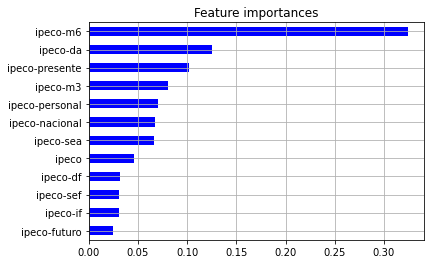

X_train shape: (209, 6) || X_test shape: (1, 6) || y_train shape: (209,)
['ipeco-nacional' 'ipeco-personal' 'ipeco-m3' 'ipeco-presente' 'ipeco-da'
 'ipeco-m6']


In [27]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [28]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041


# IPEC

In [29]:
indice = 'IPEC'
X_train, X_test, y_train = gen_X_train(vipec)

X_train shape: (233, 12) || X_test shape: (1, 12) || y_train shape: (233,)


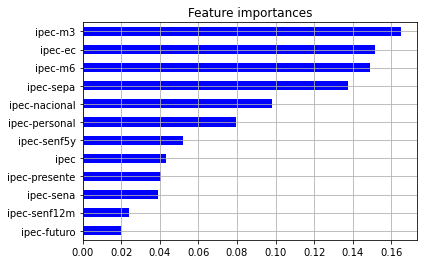

X_train shape: (233, 6) || X_test shape: (1, 6) || y_train shape: (233,)
['ipec-personal' 'ipec-nacional' 'ipec-sepa' 'ipec-m6' 'ipec-ec' 'ipec-m3']


In [30]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [31]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155


# ICE

In [32]:
indice = 'ICE'
X_train, X_test, y_train = gen_X_train(vice)

X_train shape: (198, 16) || X_test shape: (1, 16) || y_train shape: (198,)


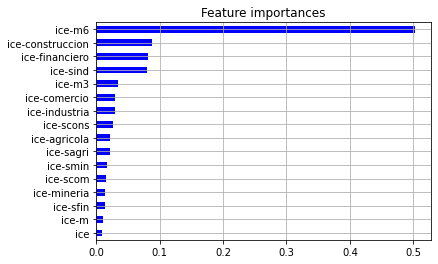

X_train shape: (200, 8) || X_test shape: (1, 8) || y_train shape: (200,)
['ice-scons' 'ice-industria' 'ice-comercio' 'ice-m3' 'ice-sind'
 'ice-financiero' 'ice-construccion' 'ice-m6']


In [33]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [34]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155
ICE,3.9649,1.8570,1.2780,0.8456


# IMCE

In [35]:
indice = 'IMCE'
X_train, X_test, y_train = gen_X_train(vimce)

X_train shape: (213, 12) || X_test shape: (1, 12) || y_train shape: (213,)


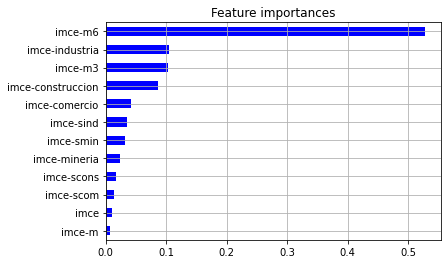

X_train shape: (213, 6) || X_test shape: (1, 6) || y_train shape: (213,)
['imce-sind' 'imce-comercio' 'imce-construccion' 'imce-m3'
 'imce-industria' 'imce-m6']


In [36]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [37]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155
ICE,3.9649,1.8570,1.2780,0.8456
IMCE,4.1008,1.6321,1.1435,0.8791


# Confianza de los consumidores

In [38]:
indice = 'Consumidores'
X_train, X_test, y_train = gen_X_train(vconsumidores)

X_train shape: (209, 24) || X_test shape: (1, 24) || y_train shape: (209,)


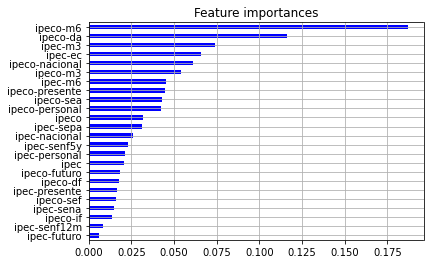

X_train shape: (209, 12) || X_test shape: (1, 12) || y_train shape: (209,)
['ipec-sepa' 'ipeco' 'ipeco-personal' 'ipeco-sea' 'ipeco-presente'
 'ipec-m6' 'ipeco-m3' 'ipeco-nacional' 'ipec-ec' 'ipec-m3' 'ipeco-da'
 'ipeco-m6']


In [39]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [40]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 2, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155
ICE,3.9649,1.8570,1.2780,0.8456
IMCE,4.1008,1.6321,1.1435,0.8791
Consumidores,5.2662,1.7951,1.3176,0.8520


# Confianza empresarial

In [41]:
indice = 'Empresarios'
X_train, X_test, y_train = gen_X_train(vempresarios)

X_train shape: (198, 28) || X_test shape: (1, 28) || y_train shape: (198,)


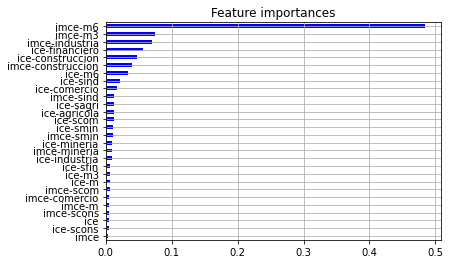

X_train shape: (198, 14) || X_test shape: (1, 14) || y_train shape: (198,)
['ice-smin' 'ice-scom' 'ice-agricola' 'ice-sagri' 'imce-sind'
 'ice-comercio' 'ice-sind' 'ice-m6' 'imce-construccion' 'ice-construccion'
 'ice-financiero' 'imce-industria' 'imce-m3' 'imce-m6']


In [42]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [43]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 0.5, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 12, 'n_estimators': 300}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155
ICE,3.9649,1.8570,1.2780,0.8456
IMCE,4.1008,1.6321,1.1435,0.8791
Consumidores,5.2662,1.7951,1.3176,0.8520
Empresarios,3.9897,0.5966,0.4112,0.9842


# Todos los índices

In [44]:
indice = 'Todos'
X_train, X_test, y_train = gen_X_train(X_train0.columns)

X_train shape: (198, 52) || X_test shape: (1, 52) || y_train shape: (198,)


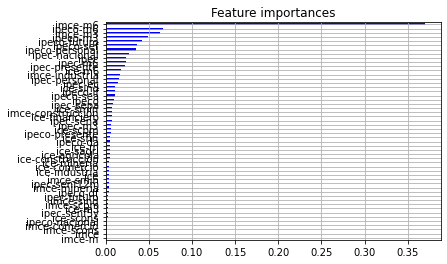

X_train shape: (200, 26) || X_test shape: (1, 26) || y_train shape: (200,)
['ice-scom' 'ipec-m3' 'ipec-sena' 'ice-financiero' 'imce-construccion'
 'ice-smin' 'ipec-sepa' 'ipeco' 'ipeco-sea' 'ipeco-if' 'ice-sind'
 'ipec-ec' 'ipec-personal' 'imce-industria' 'ice-m6' 'ipec-presente'
 'ipec-m6' 'ipec' 'ipec-nacional' 'ipeco-personal' 'ipeco-sef'
 'ipeco-futuro' 'ipeco-m3' 'imce-m3' 'ipeco-m6' 'imce-m6']


In [45]:
model = RandomForestRegressor(random_state=123, n_estimators=100)
model.fit(X_train, y_train)

fimp = pd.Series(model.feature_importances_, index=X_train.columns)
sfimp = fimp.sort_values()
sfimp.plot(kind='barh', color='blue')
plt.title('Feature importances')
plt.grid()
plt.show()

n = int(len(sfimp)/2)
subset = sfimp[-n:].index
X_train, X_test, y_train = gen_X_train(subset)
samples = samples.append(pd.DataFrame({'rows': X_train.shape[0], 'cols': X_train.shape[1]}, index=[indice]))
print(X_train.columns.values)

In [46]:
model = xgb.XGBRegressor(random_state=123)
params = {'colsample_bytree': [0.5, 1.0],
          'n_estimators': [100, 200, 300],
          'max_depth': [2, 3, 4],
          'eta': [0.01, 0.1],
          'min_child_weight': [9, 12]}
searcher = GridSearchCV(estimator=model, 
                        param_grid=params, 
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                        n_jobs=-1)
searcher.fit(X_train, y_train)
print("Best CV params", searcher.best_params_)

y_train_pred = searcher.best_estimator_.predict(X_train)
y_pred = searcher.best_estimator_.predict(X_test)
predicciones = predicciones.append(pd.DataFrame(y_pred, index=[indice], columns=['Imacec']))

results = results.append(get_metrics(indice, y_train, y_train_pred))
results.round(4)

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[14:22:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best CV params {'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 9, 'n_estimators': 100}


,CV_RMSE,RMSE,MAE,R2
IPECO,5.1502,2.0655,1.4276,0.8041
IPEC,4.7291,1.9306,1.4453,0.8155
ICE,3.9649,1.8570,1.2780,0.8456
IMCE,4.1008,1.6321,1.1435,0.8791
Consumidores,5.2662,1.7951,1.3176,0.8520
Empresarios,3.9897,0.5966,0.4112,0.9842
Todos,3.6872,0.7888,0.5956,0.9721


# Evaluación según resultados en CV y train set

In [47]:
samples

,rows,cols
IPECO,209,6
IPEC,233,6
ICE,200,8
IMCE,213,6
Consumidores,209,12
Empresarios,198,14
Todos,200,26


In [48]:
results['Ratio'] = (results['CV_RMSE'] / results['RMSE']).round(2)
print('Best models:')
print(results[['CV_RMSE', 'RMSE', 'MAE', 'Ratio']].idxmin(), '\n')
print('Best R2:')
print(results[['R2']].idxmax(), '\n')
results.round(2)

Best models:
CV_RMSE          Todos
RMSE       Empresarios
MAE        Empresarios
Ratio              ICE
dtype: object 

Best R2:
R2    Empresarios
dtype: object 



,CV_RMSE,RMSE,MAE,R2,Ratio
IPECO,5.15,2.07,1.43,0.80,2.49
IPEC,4.73,1.93,1.45,0.82,2.45
ICE,3.96,1.86,1.28,0.85,2.14
IMCE,4.10,1.63,1.14,0.88,2.51
Consumidores,5.27,1.80,1.32,0.85,2.93
Empresarios,3.99,0.60,0.41,0.98,6.69
Todos,3.69,0.79,0.60,0.97,4.67


In [59]:
predicciones = predicciones.reset_index()
predicciones.columns = ['percepcion', 'prediccion']
predicciones.round(2)

,level_0,index,percepcion,prediccion
0,0,0,IPECO,3.92
1,1,1,IPEC,10.43
2,2,2,ICE,5.12
3,3,3,IMCE,7.26
4,4,4,Consumidores,6.91
5,5,5,Empresarios,6.94
6,6,6,Todos,5.20


In [50]:
print('Mayor predicción:')
print(predicciones['prediccion'].idxmax(), '\n')

print('Menor predicción:')
print(predicciones['prediccion'].idxmin(), '\n')

Mayor predicción:
1 

Menor predicción:
0 



In [51]:
print('Predicción de la encuesta de expectativas económicas:')
pd.read_csv('https://raw.githubusercontent.com/percepcioneseconomicas/indices/main/BC%20EEE%20PIB%20e%20IMACEC.csv', index_col='Fecha')['IMACEC un mes atrás'].tail(1)

Predicción de la encuesta de expectativas económicas:


Fecha
01-02-2022    9.3
Name: IMACEC un mes atrás, dtype: float64

In [52]:
# ACTUALIZAR nombre de documento
predicciones.to_csv('pred_2022_02.csv', index=False)